In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from LombScargle import periodogram, psd
from hypothesis_testing.bayes_factor import logB
from quasars import prep

from simulations.util import  *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [13]:
import jax
import jax.numpy as jnp
from scipy.optimize import minimize
#from jax.scipy.optimize import minimize

from hypothesis_testing import quad

from typing import NamedTuple, Any
from LombScargle import periodogram, psd

scheme_d2 = quad.get_scheme(2, 6)
scheme_d3 = quad.get_scheme(3, 7)


# optimization and integration will be performed with respect to unconstrained parameters y = log z,
# where z are either (freq, sigma, tau) or (sigma tau), all positive.


class ModeInfo(NamedTuple):
    y: Any # parameter location of the mode
    nlogp: float # -log p(z(y))
    cov: Any # Covariance matrix (in y parametrization) = Hessian^-1, where H_ij = partial_i partial_j -log p(y)


def quadrature(nlogp, MAP, quad_scheme):
    """ 3d Gaussian quadrature integration for the Bayesian evidence. We want to evaluate 
            Z = \int p(z | data) dz = \int e^{-nlogp(z | data)} dz
        The Gaussian quadrature is based on the Laplace approximation of the Hessian around MAP.

        Args:
            nlogp: a function, z is an array with 2 or 3 elements.
            MAP: MAPInfo object
    
       Returns: 
            log Z (ignoring the amplitude parameters)
    """
    
    d = len(MAP.y)
    ### go in the basis where the covariance matrix is the identity ###
    detCov = jnp.linalg.det(MAP.cov)
    D, Q = jnp.linalg.eigh(MAP.cov)
    
    if jnp.any(D < 0.):
        return jnp.nan, False
            
    M = jnp.sqrt(2)* jnp.dot(Q, jnp.diag(jnp.sqrt(D))) 
    
    def residual_integrand(x):
        z = jnp.dot(M, x) + MAP.y
        return jnp.exp(-nlogp(z) + MAP.nlogp + jnp.sum(jnp.square(x))) # residual integrand in this basis
    
    ### do the integral ###
    points, weights = quad_scheme
    vals = jax.vmap(residual_integrand)(points)
    val = quad.integrate(vals, weights, d)
    val *= jnp.sqrt(detCov * 2**d) # for the change of basis
    log_evidence = - MAP.nlogp + jnp.log(val)
    
    return log_evidence, True
    


def logB(time, data, err_data, freq, nlogpr_logfreq, nlogpr_null, floating_mean= True, temp_func= periodogram.basic):
    """log Bayes factor for the sinusoidal variability in the correlated Gaussian noise (ignores the marginalization over the amplitude parameters)
        priors are -log density and are in terms of log parameters"""
    

    nlogpost0, nlogpost1, nloglik0, nloglik1, get_amp = psd.nlog_density(time, data, err_data, nlogpr_logfreq, nlogpr_null, floating_mean, temp_func)
  
    ### analyze the null model ###
    y_init = jnp.log(jnp.array([0.1, 120])) # mode of the prior distribution
    map0 = optimize(nlogpost0, y_init)
    log_ev0, success1 = quadrature(nlogpost0, map0, scheme_d2)
    
    #return success
    ### analyze the alternative model ###
    # find the best candidate for the alternative
    cov = psd.covariance(time, psd.drw_kernel(*jnp.exp(map0.y)), err_data)
    score, _ = jax.vmap(periodogram.lomb_scargle(time, data, floating_mean, jnp.linalg.cholesky(cov), temp_func= temp_func))(freq)
    score_adjusted = score - 2 * (nlogpr_logfreq(jnp.log(freq)) - nlogpr_logfreq(jnp.log(freq[len(freq)//2])))
    freq_best = freq[jnp.argmax(score_adjusted)]
    
    # compute the evidence and the uncertainty in parameters
    y_init = jnp.array([jnp.log(freq_best), *map0.y])
    map1 = optimize(nlogpost1, y_init)
    log_ev1, success2 = quadrature(nlogpost1, map1, scheme_d3)

    
    # the suboptimal test statistics, just for demonstration
    # - log likelihood ratio
    E = nloglik0(map0.y) - nloglik1(map1.y)
    
    # white noise periodogram score
    score_white, _ = jax.vmap(periodogram.lomb_scargle(time, data, floating_mean, err_data, temp_func= temp_func))(freq)
    score_white = jnp.max(score_white)
    
    ### return the log Bayes factor and the optimal parameters ###
    params = jnp.exp(map1.y)
    amp = get_amp(map1.y)
    period = 1/params[0]
    T = jnp.max(time) - jnp.min(time)
    
    return {'logB': log_ev1 - log_ev0, 'log_lik_ratio': E, 'white_periodogram': score_white,
            'cycles': T/period,
            'period': period, 'sigma': params[1], 'tau': params[2],
            'A_const': amp[0], 'A_sin': amp[1], 'A_cos': amp[2]}, success1, success2


In [17]:
def optimize(nlogp, init):
    """Given the initial guess for y = init, do optimization to maximize -logp.
       Returns:
            ModeInfo object
    """
    
    opt = minimize(jax.value_and_grad(nlogp), x0 = init, method= 'Newton-CG', 
                  jac= True, hess= jax.hessian(nlogp))#, options= {'maxiter': 200})
    #opt = minimize(nlogp, x0 = init, method = 'BFGS')
    hess = jax.hessian(nlogp)(opt.x)
    return ModeInfo(opt.x, opt.fun, jnp.linalg.inv(hess))

In [2]:
from quasars import prior

def real(id):
    
    time, data, mag_err, freq = prep.prepare_data(id)
    
    PriorAlterantive = prior.SmoothenEdge(prior.PowerLaw(-11./3., freq[0], freq[-1]), 1.2)
    PriorNull = prior.Normal()
    
    logb, s1, s2 = logB(time, data, mag_err, freq, PriorAlterantive.nlogp, PriorNull.nlogp)
    
    print(logb)

real(264194)

-0.21189064


ValueError: too many values to unpack (expected 3)

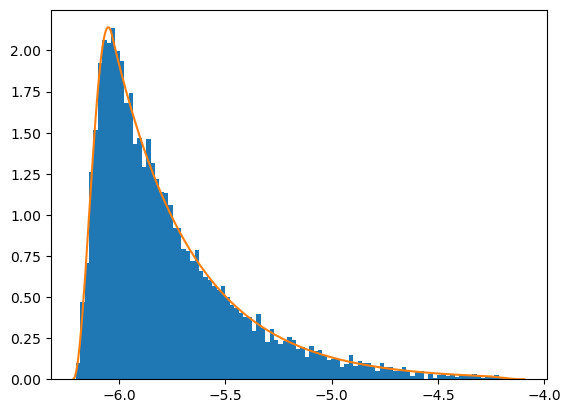

In [2]:
from quasars import prior

freq = jnp.linspace(1./500, 1./60., 1000)
Prior = prior.SmoothenEdge(prior.PowerLaw(-11./3., freq[0], freq[-1]), 1.2)

pdf = jnp.exp(-Prior.nlogp(jnp.log(freq)))
F= jax.vmap(Prior.rvs)(jax.random.split(jax.random.PRNGKey(42), 10000))

plt.hist(np.array(F), bins = 100, density= True)
plt.plot(jnp.log(freq), pdf)
plt.show()


340
590.15845
363.45392


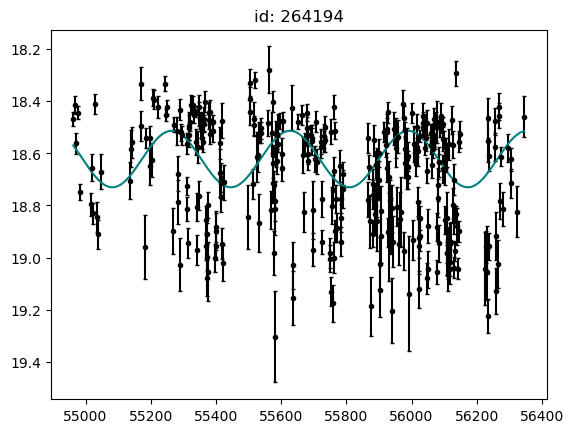

In [6]:
id = 264194
#id = 253736
time, mag, mag_err, freq, prior_params = prep.prepare_data(id)
print(len(time))

score_white, amps = jax.vmap(periodogram.lomb_scargle(time, mag, True, mag_err))(freq)
ibest = jnp.argmax(score_white)
score_white, amp = score_white[ibest], amps[ibest]
freq_best = freq[ibest]
tshift = 0
plt.title('id: ' + str(id))
plt.errorbar(time-tshift, mag, mag_err, fmt = '.', capsize = 1.3, color= 'black')
t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
model= periodogram.fit(t, freq_best, amp)
plt.plot(t-tshift, model, color = 'teal')
plt.gca().invert_yaxis()

plt.show()